In [1]:
!git clone https://github.com/sathishkumar67/Noisy_Birds.git
!mv /kaggle/working/Noisy_Birds/* /kaggle/working/
!pip install -r requirements.txt

Cloning into 'Noisy_Birds'...
remote: Enumerating objects: 1698, done.
remote: Counting objects: 100% (1698/1698), done.
remote: Compressing objects: 100% (1584/1584), done.
remote: Total 1698 (delta 182), reused 1623 (delta 111), pack-reused 0 (from 0)
Receiving objects: 100% (1698/1698), 11.56 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (182/182), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.1 MB/s eta 0:00:0000:01


In [2]:
from __future__ import annotations
from typing import Tuple
import gin
import torch
import torch.nn as nn
import lightning as L
from dataclasses import dataclass
from mae.encoder import *
from mae.decoder import *

# @gin.configurable
@dataclass
class MAEWrapperConfig:
    lr: float = 3e-4
    batch_size: int = 64
    num_epochs: int = 10
    weight_decay: float = 0.0001
    eps: float = 1e-8
    seed: int = 42
    betas: Tuple[float, float] = (0.9, 0.999)
    gpu_count: int = 1 
    device: str = "cuda"

class MAE(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoder_op, mask, ids_restore = self.encoder(x)
        decoder_op = self.decoder((encoder_op, mask, ids_restore), x)
        return decoder_op

class MAEWrapper(L.LightningModule):
    def __init__(self, mae: nn.Module, config: MAEWrapperConfig):
        super().__init__()
        self.config = config
        self.model = mae
        self.optimizer = self.configure_optimizers()

    def training_step(self, batch, batch_idx):
        self.model.train()
        optimizer = self.optimizers()
        optimizer.zero_grad()
        batch, _ = batch
        _, loss = self.model(batch)
        self.log("Train_Loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.model.eval()
        batch, _ = batch
        _, loss = self.model(batch)
        self.log("Val_Loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.config.lr, betas=self.config.betas, eps=self.config.eps, weight_decay=self.config.weight_decay)
        return optimizer            

In [3]:
from __future__ import annotations
import gin
import torch
from torch.utils.data import DataLoader
import lightning as L

from dataset import Birddataset
from mae.encoder import *
from mae.decoder import *
from model import MAE, MAEWrapper, MAEWrapperConfig

In [4]:
wrapper_config = MAEWrapperConfig()

# Load the dataset
train_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "train")
test_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "test")

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=wrapper_config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=wrapper_config.batch_size, shuffle=False)

In [5]:
# Load the encoder and decoder configs
gin.parse_config_file("/kaggle/working/config/encoder_config1.gin")
encoder_config = EncoderConfig()
gin.parse_config_file("/kaggle/working/config/decoder_config1.gin")
decoder_config = DecoderConfig()

# load the encoder model
encoder = EncoderModel(encoder_config)
encoder.to("cuda:0")
# load the decoder model
decoder = DecoderModel(decoder_config)
decoder.to("cuda:0")
# load mae model
mae_model = MAE(encoder=encoder, decoder=decoder)
mae_model.to("cuda:0")
# load the wrapper model
wrapper_model = MAEWrapper(mae_model, wrapper_config)


In [6]:
optimizer = torch.optim.AdamW(mae_model.parameters(), lr=0.001)

In [14]:
encoder_op, mask, ids_restore = encoder(img.to("cuda:0"))
decoder_op = decoder((encoder_op, mask, ids_restore), img.to("cuda:0"))

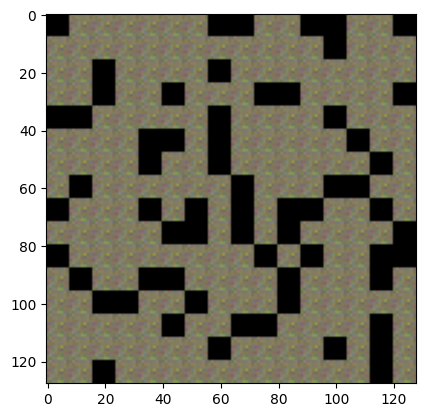

In [15]:
plt.imshow(decoder_op[0][0].permute(1, 2, 0).detach().cpu().numpy())

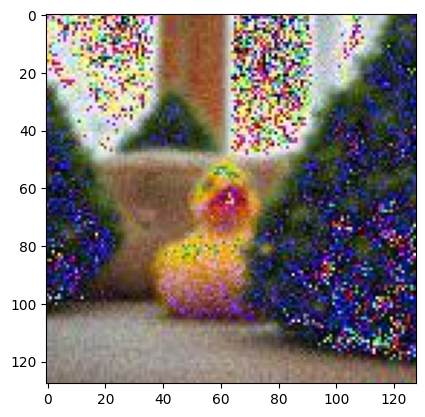

In [7]:
img, label = next(iter(train_loader))
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0).numpy())

In [10]:
for _ in range(5):
    avg_loss = 0
    for batch, _ in train_loader:
        _, loss, _, _ = mae_model(batch.to("cuda:0"))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss+=loss
        del batch
    print(f"Loss:{avg_loss/len(train_loader)}")
    avg_loss = 0

Loss:3018.90380859375
Loss:3032.3505859375
Loss:3024.84912109375
Loss:3041.808349609375
Loss:3023.9248046875


In [18]:
wrapper_model.model(img)[0]

tensor([[[[-1.0775e-01, -1.1713e-01, -1.2030e-01,  ..., -1.0995e-01,
           -1.1615e-01, -1.2578e-01],
          [-1.2195e-01, -1.1185e-01, -1.2758e-01,  ..., -1.3654e-01,
           -1.0909e-01, -1.2881e-01],
          [-1.1259e-01, -1.1553e-01, -1.1449e-01,  ..., -1.3058e-01,
           -1.2771e-01, -1.1555e-01],
          ...,
          [-3.0074e-02, -6.6457e-02, -7.0700e-02,  ..., -1.1418e-01,
           -1.1714e-01, -1.0875e-01],
          [-2.5045e-02, -1.0922e-01, -4.4480e-02,  ..., -1.2582e-01,
           -1.3318e-01, -1.1504e-01],
          [-5.9384e-02, -5.5298e-02, -7.9064e-02,  ..., -1.1652e-01,
           -1.1766e-01, -1.3620e-01]],

         [[-6.2631e-02, -6.1741e-02, -5.7896e-02,  ..., -7.2784e-02,
           -7.7675e-02, -6.6087e-02],
          [-5.6538e-02, -7.4522e-02, -6.7868e-02,  ..., -7.3317e-02,
           -8.4207e-02, -7.1108e-02],
          [-6.6101e-02, -7.4639e-02, -6.2503e-02,  ..., -6.6526e-02,
           -7.5895e-02, -7.9570e-02],
          ...,
     

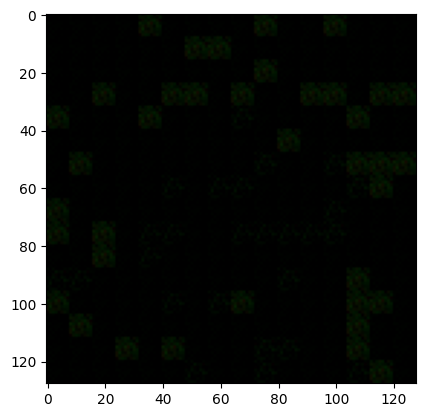

In [17]:
import matplotlib.pyplot as plt
plt.imshow(wrapper_model.model(img)[0][0].permute(1, 2, 0).detach().cpu().numpy())

In [9]:
trainer = L.Trainer(max_epochs=wrapper_config.num_epochs, accelerator="cuda", devices=1)
trainer.fit(wrapper_model, train_loader, test_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | MAE  | 5.5 M  | train
---------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
21.994    Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
